#Setup

##Mount Drive *(ignore if not in google colab)*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Copy Files *(ignore if not in google colab)*

In [2]:
!cp -r /content/drive/'My Drive'/'Colab Notebooks'/InfoSense/* . # Ignore this line if you have the notebook in the working directory

##Python Imports

In [3]:
!pip install bioinfokit

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import vmo_copy.analysis as van

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Loading VMOs from file

In [5]:
songs = ['bach', 'telemanF', 'telemanR', 'shakuhachi', 'nanguan']
song_names = ['Bach', 'Telemann Fl', 'Telemann Rec', 'Shakuhachi', 'Nanguan']
features = ['vae_all', 'vae_self', 'vae_exclude', 'mfcc', 'chroma']
feature_names = ['$VAE_{all}$', '$VAE_{self}$', '$VAE_{ex}$', 'MFCC', 'Chroma']

data = dict()
for song in songs:
    data[song] = dict()
    for feature in features:
        data[song][feature] = dict()
        pickle_file = 'models/%s_%s_vmo.pkl' % (song, feature)
        try:
            with open(pickle_file, 'rb') as f:
                data[song][feature]['features'] = pickle.load(f)
                data[song][feature]['ideal_t'] = pickle.load(f)
                data[song][feature]['oracle'] = pickle.load(f)
        except FileNotFoundError:
            print('%s does not exist' % pickle_file)

#IR Profiles

In [6]:
def plot_IR_profile(ideal_t, range=(0,1), ax=None):
    x_t = np.array([t[1] for t in ideal_t[1] if range[0]<=t[1]<=range[1]])
    y_t = [t[0] for t in ideal_t[1] if range[0]<=t[1]<=range[1]]
    if ax is None:
        plt.plot(x_t, y_t, linewidth = 2)
        ymin, ymax = plt.ylim()
        plt.vlines(ideal_t[0][1], 0, ymax, colors='r')
    else:
        ax.plot(x_t, y_t, linewidth = 2)
        ymin, ymax = ax.get_ylim()
        ax.vlines(ideal_t[0][1], 0, ymax, colors='r')

Song & $VAE_{all}$ & $VAE_{self}$ & $VAE_{exclude}$ & MFCC & Chroma\\
Bach & 0.680 & 0.800 & 0.600 & 0.440 & 0.540\\
Telemann Fl & 0.750 & 0.780 & 0.700 & 0.230 & 0.460\\
Telemann Rec & 0.740 & 0.800 & 0.670 & 0.320 & 0.510\\
Shakuhachi & 0.550 & 0.550 & 0.500 & 0.150 & 0.060\\
Nanguan & 0.510 & 0.640 & 0.400 & 0.060 & 0.060\\


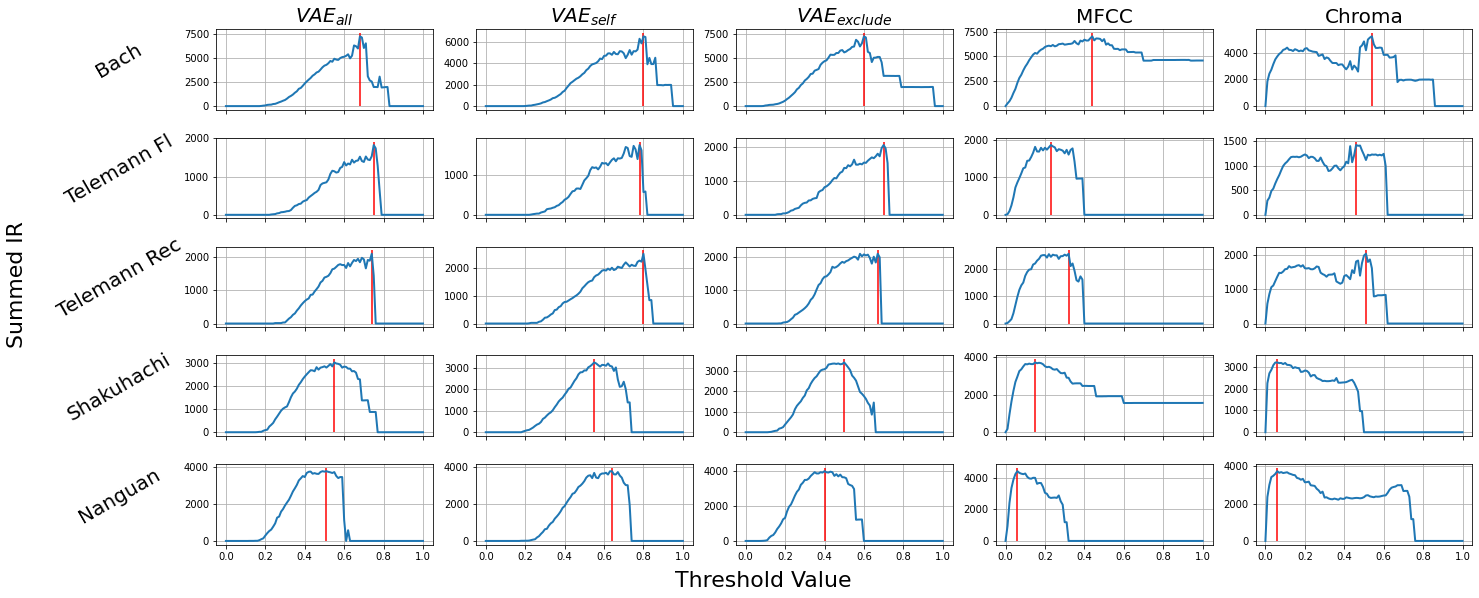

In [17]:
songs = ['bach', 'telemanF', 'telemanR', 'shakuhachi', 'nanguan']
song_names = ['Bach', 'Telemann Fl', 'Telemann Rec', 'Shakuhachi', 'Nanguan']
features = ['vae_all', 'vae_self', 'vae_exclude', 'mfcc', 'chroma']
feature_names = ['$VAE_{all}$', '$VAE_{self}$', '$VAE_{exclude}$', 'MFCC', 'Chroma']

fig, axmain = plt.subplots(nrows=len(songs), ncols=len(features), sharex='all', figsize=(20, 8)) #(12,10)

fig.text(0.5, -0.025, 'Threshold Value', ha='center', fontsize = 22)
fig.text(-0.025, 0.5, 'Summed IR', va='center', rotation='vertical',fontsize = 22)

s = 'Song'
for feature_name in feature_names:
    s += ' & ' + feature_name
print(s + '\\\\')
for i, song, song_name in zip(range(len(songs)), songs, song_names):
    s = song_name
    for j, feature, feature_name in zip(range(len(features)), features, feature_names):
        ax = axmain[i][j]
        if i == 0:
            ax.set_title(feature_name, fontsize=20)
        if j == 0:
            ax.set_ylabel(song_name, fontsize=20, rotation=30, labelpad=60)
        plot_IR_profile(data[song][feature]['ideal_t'], ax=ax)
        ax.grid('on')
        s += ' & ' + '%0.3f'%(data[song][feature]['ideal_t'][0][1])
    print(s + '\\\\')
plt.tight_layout()

filename = 'IR_profiles.pdf'
fig.savefig(filename, format='pdf', bbox_inches="tight")
!cp {filename} /content/drive/'My Drive'/'Colab Notebooks'/InfoSense/{filename} 

#Pattern Plot

In [8]:
def plot_patterns(oracle, ax=None):
    pattern = van.find_repeated_patterns(oracle, lower=2)
    pattern_mat = np.zeros((len(pattern), oracle.n_states-1))
    for i,p in enumerate(pattern):
        length = p[1]
        for s in p[0]:
            pattern_mat[i][s-length:s-1] = 1
    if ax is None: plt.imshow(pattern_mat, interpolation = 'nearest', aspect = 'auto', cmap = 'Greys')
    else: ax.imshow(pattern_mat, interpolation = 'nearest', aspect = 'auto', cmap = 'Greys')

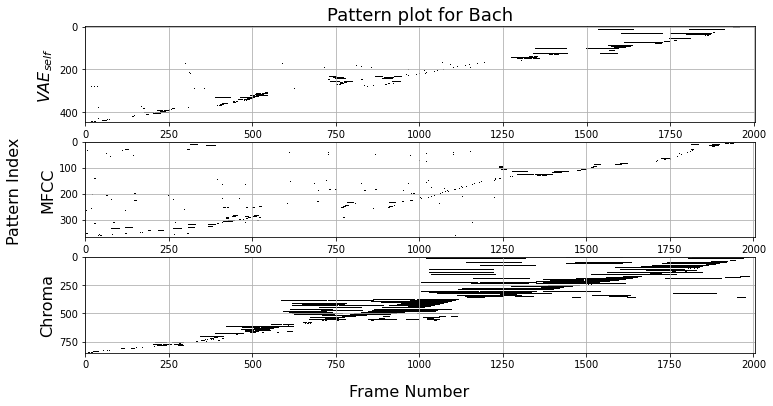

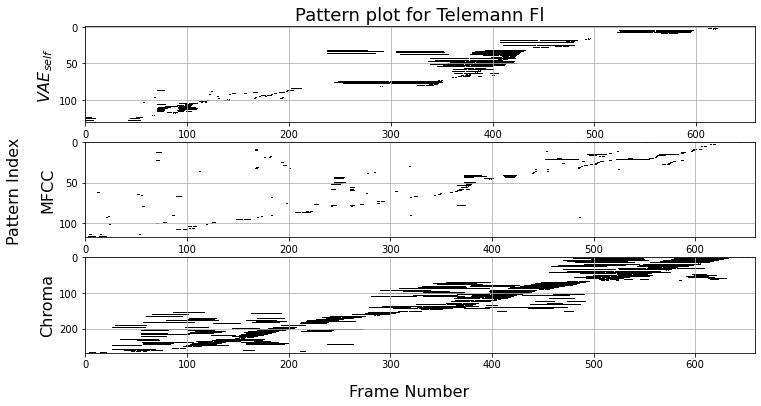

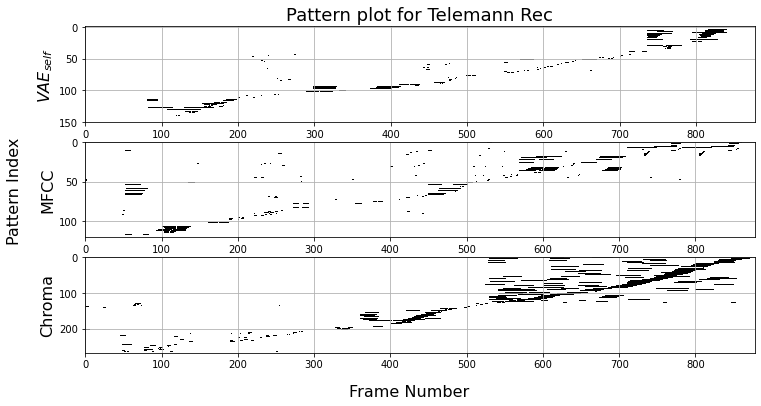

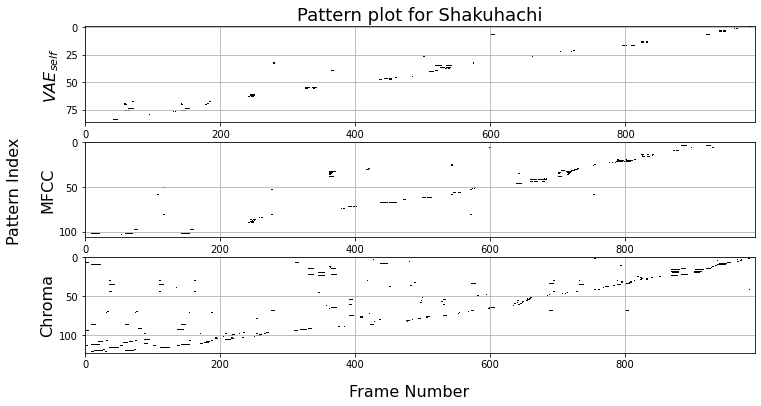

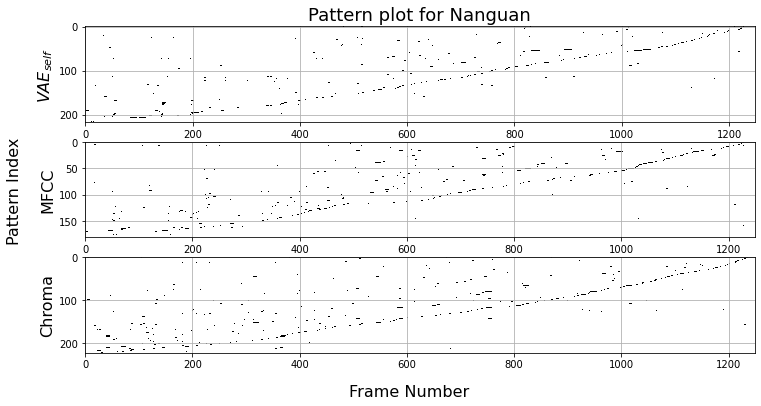

In [15]:
songs = ['bach', 'telemanF', 'telemanR', 'shakuhachi', 'nanguan']
song_names = ['Bach', 'Telemann Fl', 'Telemann Rec', 'Shakuhachi', 'Nanguan']
features = ['vae_self', 'mfcc', 'chroma']
feature_names = ['$VAE_{self}$', 'MFCC', 'Chroma']

for song, song_name in zip(songs, song_names):
    fig, axmain = plt.subplots(nrows=len(features), ncols=1, figsize=(12, 2*len(features))) #(12,10)
    fig.text(0.5, 0.025, 'Frame Number', ha='center', fontsize = 16)
    fig.text(0.035, 0.5, 'Pattern Index', va='center', rotation='vertical',fontsize = 16)
    for j, feature, feature_name in zip(range(len(features)), features, feature_names):
        ax = axmain[j]
        if j == 0:
            ax.set_title('Pattern plot for %s' % song_name, fontsize=18)
        plot_patterns(data[song][feature]['oracle'], ax=ax)
        ax.grid('on')
        ax.set_ylabel(feature_name, fontsize=16)
        
    filename = '%s_pattern_plot_%d.pdf' % (song, len(features))
    plt.savefig(filename, format='pdf')
    !cp {filename} /content/drive/'My Drive'/'Colab Notebooks'/InfoSense/{filename} 

#Pattern Statistic Chart

In [10]:
import vmo_copy.analysis as van

songs = ['bach', 'telemanF', 'telemanR', 'shakuhachi', 'nanguan']
song_names = ['Bach', 'Telemann Fl', 'Telemann Rec', 'Shakuhachi', 'Nanguan']
features = ['vae_all', 'vae_self', 'vae_exclude', 'mfcc', 'chroma']
feature_names = ['$VAE_{all}$', '$VAE_{self}$', '$VAE_{exclude}$', 'MFCC', 'Chroma']

def plot_pattern_avg_std(songs=songs, song_names=song_names, features=features, feature_names=feature_names):
    if feature_names is None: feature_names = features
    assert len(feature_names) == len(features)
    if song_names is None: song_names = songs
    assert len(song_names) == len(songs)
    X = np.arange(len(songs))
    width = 1 / (len(features) + 1)
    for i, feature in enumerate(features):
        patterns = [van.find_repeated_patterns(data[song][feature]['oracle'], lower=2) for song in songs]
        average = [np.mean([p[1] for p in pattern]) for pattern in patterns]
        stds = [np.std([p[1] for p in pattern]) for pattern in patterns]

        plt.bar(X+i*width, average, width=width, label=feature_names[i], yerr=stds, capsize=10, ecolor='k')
    plt.xticks(X+(len(features)-1)*width/2, song_names, fontsize = 14)
    plt.legend()

def plot_pattern_violin(songs=songs, song_names=song_names, features=features, feature_names=feature_names):
    if feature_names is None: feature_names = features
    assert len(feature_names) == len(features)
    if song_names is None: song_names = songs
    assert len(song_names) == len(songs)
    X = np.arange(len(songs))
    width = 1 / (len(features) + 1)
    plots = []
    for i, feature in enumerate(features):
        patterns = [van.find_repeated_patterns(data[song][feature]['oracle'], lower=2) for song in songs]
        lengths = [[p[1] for p in pattern] for pattern in patterns]

        plots.append(plt.violinplot(lengths, positions=X+i*width, widths=width, showextrema=False, showmeans=True)['bodies'][0])
    plt.xticks(X+(len(features)-1)*width/2, song_names, fontsize = 14)
    plt.legend(plots, feature_names, fontsize = 14)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


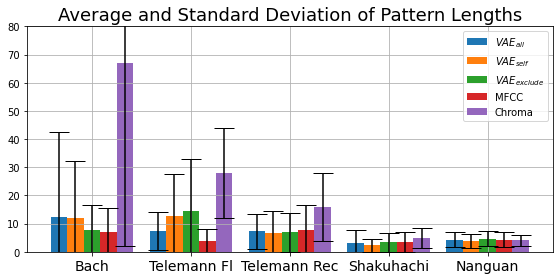

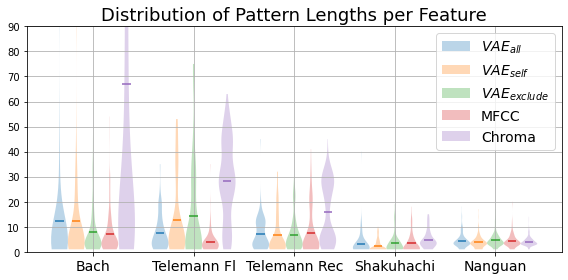

In [14]:
plt.figure(figsize = (8,4))
plot_pattern_avg_std()
plt.title('Average and Standard Deviation of Pattern Lengths', fontsize = 18)
plt.grid('on')
plt.ylim([0,80])
plt.tight_layout()
    
filename = 'pattern_length_stats_bar_%d.pdf' % (len(features))
plt.savefig(filename, format='pdf')
!cp {filename} /content/drive/'My Drive'/'Colab Notebooks'/InfoSense/{filename} 


plt.figure(figsize = (8,4))
plot_pattern_violin()
plt.title('Distribution of Pattern Lengths per Feature', fontsize = 18)
plt.grid('on')
plt.ylim([0,90])
plt.tight_layout()
    
filename = 'pattern_length_stats_violin_%d.pdf' % (len(features))
plt.savefig(filename, format='pdf')
!cp {filename} /content/drive/'My Drive'/'Colab Notebooks'/InfoSense/{filename} 

#ANOVA Test

In [12]:
for i, feature in enumerate(features):
    patterns = [van.find_repeated_patterns(data[song][feature]['oracle'], lower=3) for song in songs]
    lengths = [[p[1] for p in pattern] for pattern in patterns]
    fvalue, pvalue = stats.f_oneway(lengths[0], lengths[1], lengths[2], lengths[3], lengths[4])
    print(feature)
    print("F-Value", fvalue)
    print("p-Value", pvalue)
    flat_list = []
    flat_lables = []
    for i, sublist in enumerate(lengths):
        for item in sublist:
            flat_list.append(item)
            flat_lables.append(songs[i])
    m_comp = pairwise_tukeyhsd(endog=flat_list, groups=flat_lables, alpha=0.05)
    print(m_comp)
    print()

vae_all
F-Value 7.065989540529919
p-Value 1.319548290627838e-05
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower    upper  reject
-------------------------------------------------------------
      bach    nanguan  -8.3049  0.001 -13.9822 -2.6275   True
      bach shakuhachi -10.1023  0.001  -17.213 -2.9917   True
      bach   telemanF  -5.5323 0.0812 -11.4645     0.4  False
      bach   telemanR   -5.555 0.0311 -10.7879 -0.3222   True
   nanguan shakuhachi  -1.7975    0.9  -9.9241  6.3292  False
   nanguan   telemanF   2.7726 0.8012  -4.3459   9.891  False
   nanguan   telemanR   2.7498 0.7539  -3.7972  9.2969  False
shakuhachi   telemanF   4.5701 0.5523  -3.7367 12.8768  False
shakuhachi   telemanR   4.5473  0.504  -3.2753 12.3699  False
  telemanF   telemanR  -0.0227    0.9   -6.792  6.7465  False
-------------------------------------------------------------

vae_self
F-Value 16.758375173860475
p-Value 3.1043253739539565e-13


In [13]:
for i, feature in enumerate(features):
    patterns = [van.find_repeated_patterns(data[song][feature]['oracle'], lower=2) for song in songs]
    lengths = [[p[1] for p in pattern] for pattern in patterns]
    fvalue, pvalue = stats.f_oneway(lengths[0]+lengths[1]+lengths[2], lengths[3]+lengths[4])
    print(feature)
    print("F-Value", fvalue)
    print("p-Value", pvalue)
    print()

vae_all
F-Value 20.858992104187145
p-Value 5.498693392894269e-06

vae_self
F-Value 58.16869635339964
p-Value 5.4393754205669425e-14

vae_exclude
F-Value 49.18966183737753
p-Value 4.353516761015571e-12

mfcc
F-Value 29.272468712490635
p-Value 8.075361268387932e-08

chroma
F-Value 223.7774324704196
p-Value 1.1498409139637056e-47

